# GPA prediction by Different ML models

## Load libraries and read file

In [2]:
# load all necessary libraries
import pandas as pd 
import numpy as np 
import scipy as scp
import seaborn as sns
import random
import sklearn
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#df_test = pd.read_spss('data/newdata/مهندسی.sav')
df_test = pd.read_excel('data/data_w_origin/GHOMOYAT.xlsx')
df_GPA = pd.read_spss('data/GPA.sav')
print(df_test.shape)

(15363, 19)


In [3]:
df_GPA.head()

,GPA,RGPA,DF
0,14.00,0.099752,0.129663
1,14.00,0.099752,0.129663
2,12.61,0.037712,-0.013209
3,13.93,0.095156,0.121958
4,18.90,0.899117,0.868554


In [4]:
# correct age column
import re
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

df_test['Sen']=df_test['Sen'].apply(lambda cw : remove_tags(cw))
#df_test.head()

def age_calc(string):
    year, month, day = string.split("/")
    year = 1401 - int(year)
    return year

df_test['Sen']=df_test['Sen'].apply(lambda cw : age_calc(cw))
df_test['GPA_norm'] = df_GPA['RGPA']

In [6]:
'''
cols = ['Danshkadeh', 'Sen', 'Maghtah', 'Type', 'Moadel', 'Meliyat',
       'Vaziyat Tahol', 'Farzandan', 'Sal', 'Komak Mali', 'Jensiyat',
       'Eteghal', 'Enseraf', 'Hazf', 'Morakhasi', 'Tagher Reshteh', 'Mehman',
       'Mantagheh', 'GDP']
'''       

cols = ['Department', 'Age', 'Grade', 'Type', 'GPA', 'Nationality',
         "Marital status", "Children", "Year", "Financial Aid", "Gender",
         "Transfer", "Drop out", "Remove", "Leave", "Change field", "Guest",
         "Region", "Gross Domestic Product", "GPA_norm"]
df_test.columns = cols
#df_test.drop(['Region', 'Gross Domestic Product'], axis=1, inplace=True)
df_test.drop(['Region', 'Gross Domestic Product', 'Transfer', 'Drop out', 'Remove', 'Leave', 'Change field', 'Guest'], axis=1, inplace=True)
df_test.columns
df_test = df_test.loc[~(df_test == 999).any(axis=1)]

df_test.head()

,Department,Age,Grade,Type,GPA,Nationality,Marital status,Children,Year,Financial Aid,Gender,GPA_norm
0,1,21,0,0,14.00,1,1,0,6,1,1,0.099752
1,1,21,0,0,14.00,1,1,0,6,1,1,0.099752
2,1,21,0,0,12.61,1,1,0,6,1,0,0.037712
3,1,22,0,0,13.93,1,1,0,6,1,1,0.095156
5,1,21,0,0,18.90,1,1,0,6,1,0,0.422095


In [7]:
# send to SPSS for GPA normalization
#import pyreadstat
#df_copy = df_test[['GPA', 'Gender']]
#pyreadstat.write_sav(df_copy, './GPA.sav')

In [8]:
# median values for discrete cols
col_median = list(df_test.columns)
col_median.remove('GPA')
df_test[col_median].median()

Department         2.000000
Age               25.000000
Grade              1.000000
Type               1.000000
Nationality        1.000000
Marital status     1.000000
Children           0.000000
Year               4.000000
Financial Aid      1.000000
Gender             1.000000
GPA_norm           0.482931
dtype: float64

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13709 entries, 0 to 15362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Department      13709 non-null  int64  
 1   Age             13709 non-null  int64  
 2   Grade           13709 non-null  int64  
 3   Type            13709 non-null  int64  
 4   GPA             13709 non-null  float64
 5   Nationality     13709 non-null  int64  
 6   Marital status  13709 non-null  int64  
 7   Children        13709 non-null  int64  
 8   Year            13709 non-null  int64  
 9   Financial Aid   13709 non-null  int64  
 10  Gender          13709 non-null  int64  
 11  GPA_norm        12265 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 1.4 MB


In [10]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Department,13709.0,2.154059,1.296688,1.000000,1.000000,2.000000,4.000000,4.000000
Age,13709.0,26.688818,6.402831,2.000000,22.000000,25.000000,29.000000,67.000000
Grade,13709.0,0.728208,0.661330,0.000000,0.000000,1.000000,1.000000,2.000000
Type,13709.0,0.759720,0.427269,0.000000,1.000000,1.000000,1.000000,1.000000
GPA,13709.0,16.777675,1.918553,10.040000,15.670000,17.170000,18.250000,20.000000
Nationality,13709.0,0.987162,0.112581,0.000000,1.000000,1.000000,1.000000,1.000000
Marital status,13709.0,0.843461,0.363379,0.000000,1.000000,1.000000,1.000000,1.000000
Children,13709.0,0.125830,0.495526,0.000000,0.000000,0.000000,0.000000,9.000000
Year,13709.0,4.043402,1.587015,1.000000,3.000000,4.000000,5.000000,6.000000
Financial Aid,13709.0,0.997155,0.053263,0.000000,1.000000,1.000000,1.000000,1.000000


## EDA

In [11]:
'''
# create a dictionary to map unique values to numbers
mapping_dict = {}
variables = list(set(df_test.columns) - {"ID", "Sen", "Moadel", "Farzandan", "Sal"})
for col in variables:
    unique_values = df_test[col].unique()
    mapping_dict[col] = {value: i for i, value in enumerate(unique_values)}

# replace values in data frame with mapped values
df_test.replace(mapping_dict, inplace=True)
df_test.head()
'''

'\n# create a dictionary to map unique values to numbers\nmapping_dict = {}\nvariables = list(set(df_test.columns) - {"ID", "Sen", "Moadel", "Farzandan", "Sal"})\nfor col in variables:\n    unique_values = df_test[col].unique()\n    mapping_dict[col] = {value: i for i, value in enumerate(unique_values)}\n\n# replace values in data frame with mapped values\ndf_test.replace(mapping_dict, inplace=True)\ndf_test.head()\n'

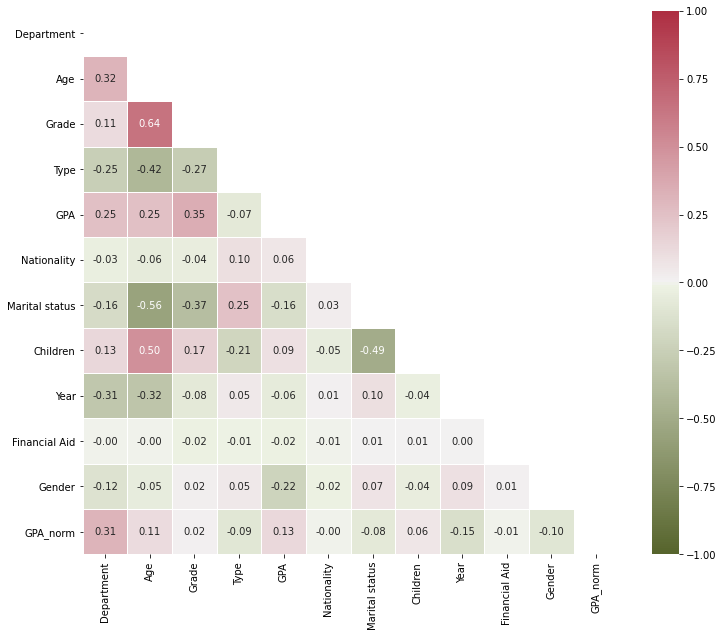

In [12]:
plt.figure(figsize=(12,10))
#sns.set_theme(style="white")

# Getting the Upper Triangle of the co-relation matrix
corr = df_test.corr()
#matrix = np.triu(corr)
#mask = np.triu(np.ones_like(corr, dtype=bool))
matrix = np.triu(np.ones_like(corr))


cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

#sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f", mask=matrix);
sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = cmap, fmt=".2f", mask=matrix);

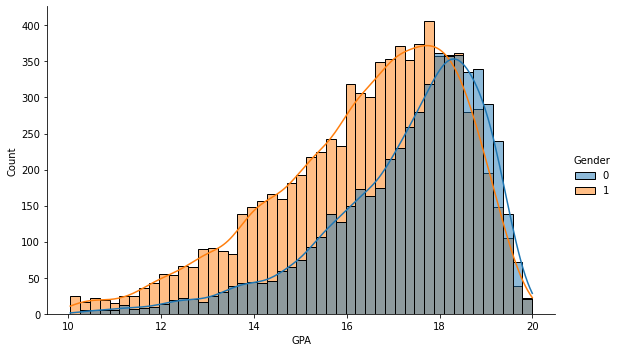

In [13]:
sns.displot(df_test, x= 'GPA', hue=df_test['Gender'], kde=True, height=5, aspect=1.6)

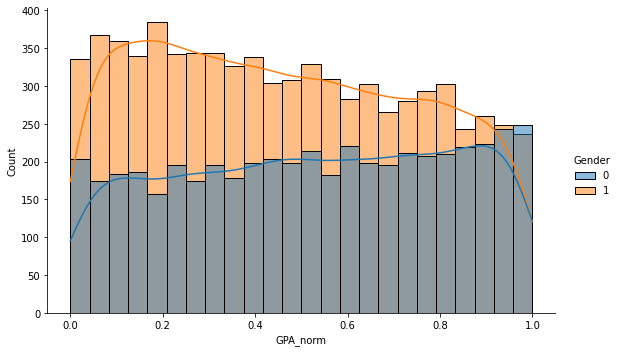

In [14]:
sns.displot(df_test, x= 'GPA_norm', hue=df_test['Gender'], kde=True, height=5, aspect=1.6)

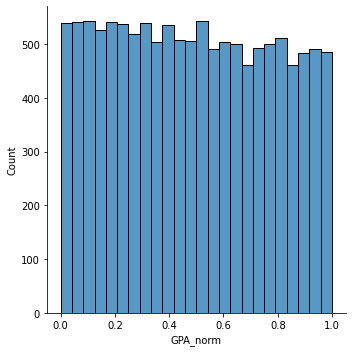

In [18]:
#sns.displot(df_test, x= 'GPA_norm', kde=True, height=5, aspect=1.6)
sns.displot(df_test, x= 'GPA_norm')

In [19]:
df_test.dropna(inplace=True)
df_test.isna().sum()

Department        0
Age               0
Grade             0
Type              0
GPA               0
Nationality       0
Marital status    0
Children          0
Year              0
Financial Aid     0
Gender            0
GPA_norm          0
dtype: int64

## Model for GPA

<Axes: >

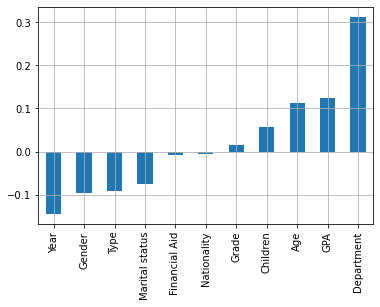

In [20]:
df_test.corr()['GPA_norm'].sort_values()[:-1].plot(kind='bar', grid=1)

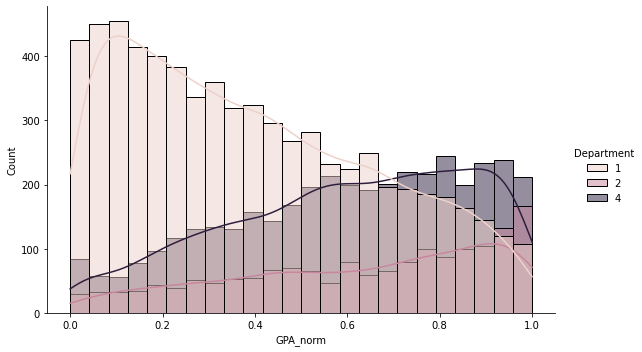

In [21]:
sns.displot(df_test, x= 'GPA_norm', hue=df_test['Department'], kde=True, height=5, aspect=1.6)

<Axes: xlabel='GPA_norm', ylabel='Count'>

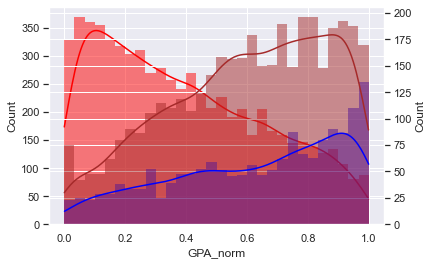

In [22]:
sns.set()
sns.histplot(df_test[df_test['Department']==1]['GPA_norm'], bins=30, linewidth=0, kde=True, color='red')
ax2 = plt.twinx()
sns.histplot(df_test[df_test['Department']==2]['GPA_norm'], bins=30, linewidth=0, kde=True, ax=ax2, color='blue')
sns.histplot(df_test[df_test['Department']==3]['GPA_norm'], bins=30, linewidth=0, kde=True, ax=ax2, color='green')
sns.histplot(df_test[df_test['Department']==4]['GPA_norm'], bins=30, linewidth=0, kde=True, ax=ax2, color='brown')

In [138]:
df_test['GPA'] = (df_test['GPA'] - df_test['GPA'].mean()) / df_test['GPA'].std()    
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#df_test['GPA'] = MinMaxScaler().fit_transform(np.array(df_test['GPA']).reshape(-1,1))
#df_test['GPA'] = StandardScaler().fit_transform(np.array(df_test['GPA']).reshape(-1,1))

df_test.head()

,Department,Age,Grade,Type,GPA,Nationality,Marital status,Children,Year,Financial Aid,Gender
0,1,21,0,0,-1.447796,1,1,0,6,1,1
1,1,21,0,0,-1.447796,1,1,0,6,1,1
2,1,21,0,0,-2.172300,1,1,0,6,1,0
3,1,22,0,0,-1.484282,1,1,0,6,1,1
5,1,21,0,0,1.106211,1,1,0,6,1,0


In [23]:
df_test['GPA_norm'].std()

0.2884660465313504

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.500043651135707, pvalue=0.0)


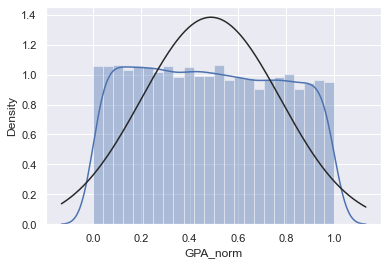

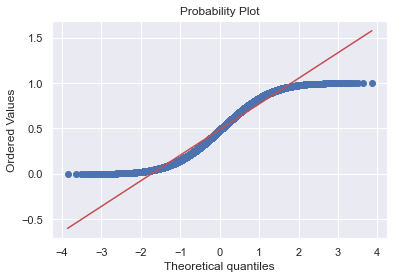

In [24]:
#histogram and normal probability plot
sns.distplot(df_test['GPA_norm'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_test['GPA_norm'], plot=plt)

ks_GPA = stats.ks_1samp(x = df_test['GPA_norm'], cdf = stats.norm.cdf)
print(ks_GPA)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


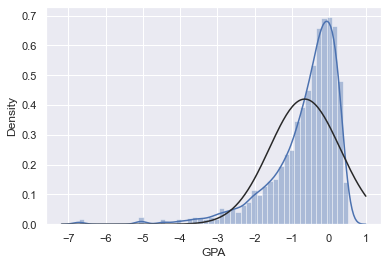

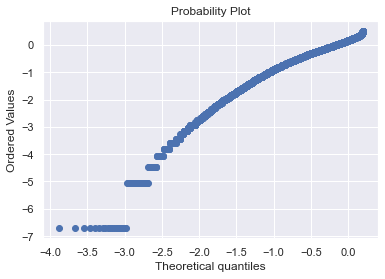

In [142]:
df_test['GPA'] = np.log(df_test['GPA'])
sns.distplot(df_test['GPA'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_test['GPA'], plot=plt)

## Linear Regression

Columns for training: ['Department', 'Age', 'Grade', 'Type', 'Nationality', 'Marital status', 'Children', 'Year', 'Financial Aid', 'Gender']


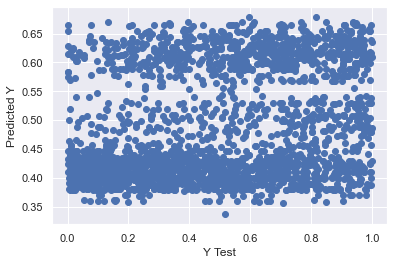

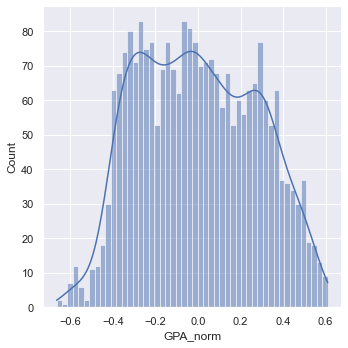

In [34]:
from sklearn.preprocessing import StandardScaler

X = df_test.drop(['GPA_norm', 'GPA'], axis=1) 
y = df_test['GPA_norm']
#y=y.astype('object')

print("Columns for training:", list(X.columns.values)) 

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([10, 20, 12., 20])

sns.displot((y_test-predictions),bins=50, kde=True);

In [35]:
coeff_df = pd.DataFrame(lm.coef_,index=X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Department,0.085153
Age,-0.001382
Grade,-0.012619
Type,-0.003523
Nationality,0.002417
Marital status,-0.008902
Children,-0.001408
Year,-0.016132
Financial Aid,-0.001235
Gender,-0.012800


Variable: Department           Importance: 0.085
Variable: Nationality          Importance: 0.002
Variable: Age                  Importance: -0.001
Variable: Children             Importance: -0.001
Variable: Financial Aid        Importance: -0.001
Variable: Type                 Importance: -0.004
Variable: Marital status       Importance: -0.009
Variable: Grade                Importance: -0.013
Variable: Gender               Importance: -0.013
Variable: Year                 Importance: -0.016


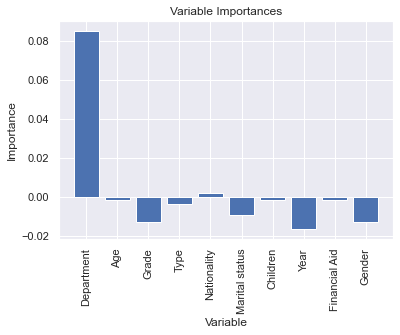

In [36]:
# Get numerical feature importances
feature_list = X.columns

importances = list(lm.coef_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid(True)

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

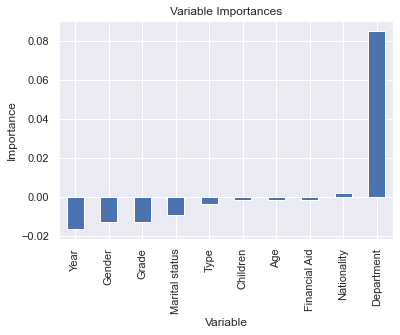

In [37]:
coeff_df['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [38]:
# calculate these metrics by hand!
from sklearn import metrics

predictions = lm.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.23300102344048682
MSE: 0.07557758141083164
RMSE: 0.2749137708643051


In [39]:
log_cols = ["Classifier", "MAE", "MSE", "RMSE"]
log 	 = pd.DataFrame(columns=log_cols)
log_entry = pd.DataFrame([["Linear Regression", metrics.mean_absolute_error(y_test, predictions), 
                           metrics.mean_squared_error(y_test, predictions),
                           np.sqrt(metrics.mean_squared_error(y_test, predictions))
                           ]], columns=log_cols)
log = log.append(log_entry)

## NN for Regression

In [40]:
X_train.shape

(9812, 10)

In [41]:
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [42]:
model = Sequential()

model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
#model.add(Dense(11,activation='relu'))
model.add(Dense(1))

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

model.compile(optimizer='adam',loss='mse')
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=10, verbose=False, callbacks=[early_stopping])

<Axes: >

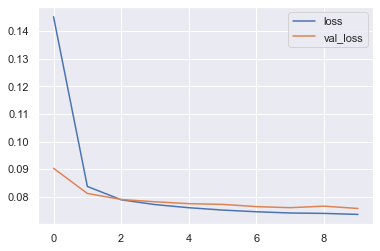

In [43]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [44]:
NN_pred = model.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, NN_pred))
print('MSE:', metrics.mean_squared_error(y_test, NN_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, NN_pred)))

77/77 [==============================] - 0s 764us/step
MAE: 0.23291581219450785
MSE: 0.07577349298556743
RMSE: 0.2752698548435107


In [45]:
log_entry = pd.DataFrame([["Neural Network", metrics.mean_absolute_error(y_test, NN_pred), 
                           metrics.mean_squared_error(y_test, NN_pred),
                           np.sqrt(metrics.mean_squared_error(y_test, NN_pred))
                           ]], columns=log_cols)
log = log.append(log_entry)

77/77 [==============================] - 0s 2ms/step


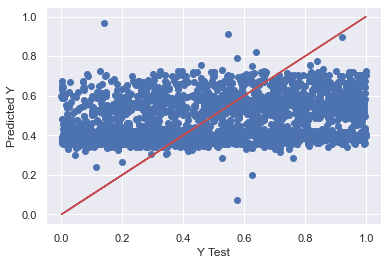

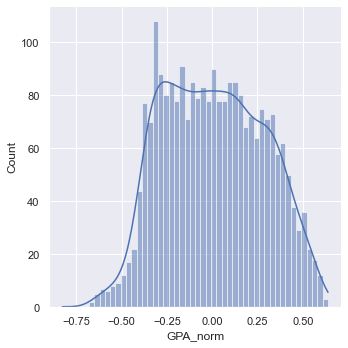

In [47]:
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0])
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.plot(y_test,y_test,'r')
#plt.axis([12, 20, 12., 22])

sns.displot((y_test-predictions),bins=50, kde=True);

In [48]:
NDIM = X_train.shape[1]

def main():
        
    keras_pipeline = Pipeline([("scaler", StandardScaler()),
                               ("clf", keras.wrappers.scikit_learn.KerasClassifier(
                                   build_fn=make_model))
    ])
    
    param_grid = {'clf__network_layers': [(32, 32), (64, 64), (128, 128, 128)],
     'clf__batch_size': [64, 128, 256, 512],
     'clf__epochs': [5, 10, 15, 50, 100, 200],
     'clf__dropout_rate': [0.1, 0.01],
     'clf__optimizer': ['Nadam', 'Adam', 'SGD'],
     'clf__activation': ['selu', 'relu', 'tanh'],
     'clf__k_initializer': ['lecun_normal', 'normal'],
     'clf__verbose': [0]
    }
    
    rs_keras = RandomizedSearchCV(keras_pipeline,
                                  param_distributions=param_grid,
                                  cv=5, refit=True,
                                  verbose=0,
                                  n_iter=5,
                                  scoring="neg_mean_squared_error")
    
    history = rs_keras.fit(np.array(X_train),
                 np.array(y_train))
    
    print('Best score obtained: {0}'.format(rs_keras.best_score_))
    print('Parameters:')
    for param, value in rs_keras.best_params_.items():
        print('\t{}: {}'.format(param, value))
    return  rs_keras  

def make_model(network_layers=[(32, 32)],
               dropout_rate=0,
               optimizer="Nadam",
               activation="selu",
               k_initializer='lecun_normal',
               n_input=NDIM,
               n_class=1):
    
    model = keras.models.Sequential()

    for index, layers in enumerate(network_layers):
        if not index:
            model.add(keras.layers.Dense(layers,
                                         input_dim=n_input,
                                         activation=activation,
                                         kernel_initializer=k_initializer))
        else:
            model.add(keras.layers.Dense(layers,
                                         kernel_initializer=k_initializer,
                                         activation=activation))
        if dropout_rate and index:
            model.add(keras.layers.AlphaDropout(dropout_rate))

    model.add(keras.layers.Dense(n_class))
    model.compile(optimizer=optimizer,loss='mse')

    #print(model.summary())
    return model

if __name__ == '__main__':
    opt_model = main()

<ipython-input-48-def92934cb05>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("clf", keras.wrappers.scikit_learn.KerasClassifier(


62/62 [==============================] - 0s 2ms/step
Best score obtained: -0.3227566635312812
Parameters:
	clf__verbose: 0
	clf__optimizer: Nadam
	clf__network_layers: (32, 32)
	clf__k_initializer: normal
	clf__epochs: 100
	clf__dropout_rate: 0.01
	clf__batch_size: 256
	clf__activation: relu


In [49]:
'''
GPA
Parameters:
	clf__verbose: 0
	clf__optimizer: SGD
	clf__network_layers: (128, 128, 128)
	clf__k_initializer: normal
	clf__epochs: 200
	clf__dropout_rate: 0.1
	clf__batch_size: 64
	clf__activation: tanh
'''

'''
GPA_norm
Parameters:
	clf__verbose: 0
	clf__optimizer: Nadam
	clf__network_layers: (32, 32)
	clf__k_initializer: normal
	clf__epochs: 100
	clf__dropout_rate: 0.01
	clf__batch_size: 256
	clf__activation: relu

'''

'\nGPA_norm\n\n'

In [62]:
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

drop_model = models.Sequential()
drop_model.add(layers.Dense(128,  kernel_initializer='lecun_normal', activation='tanh', input_shape=(NDIM,)))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(128,  kernel_initializer='lecun_normal', activation='tanh'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(128,  kernel_initializer='lecun_normal', activation='tanh'))
drop_model.add(layers.Dropout(0.1))
drop_model.add(layers.Dense(1, kernel_initializer='lecun_normal'))

# compile the model
drop_model.compile(optimizer='SGD', loss='mse')
# print the model summary
drop_model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='min')

# Train classifier
import time
start = time.time() # time at start of whole processing

drop_history = drop_model.fit(X_train, 
                    y_train, 
                    epochs=200, 
                    batch_size=64, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping], 
                    validation_data=(X_test,y_test)
                    )

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_90 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_91 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_92 (Dense)            (None, 1)               

<Axes: >

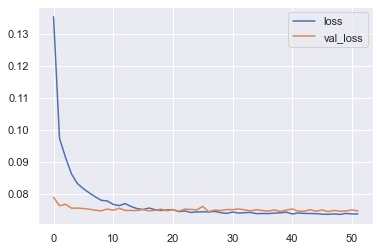

In [63]:
losses = pd.DataFrame(drop_model.history.history)
losses.plot()

In [64]:
NN_pred_opt = drop_model.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, NN_pred_opt))
print('MSE:', metrics.mean_squared_error(y_test, NN_pred_opt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, NN_pred_opt)))

77/77 [==============================] - 0s 958us/step
MAE: 0.23158100540973708
MSE: 0.07474380331606253
RMSE: 0.2733931296065476


In [65]:
log_entry = pd.DataFrame([["Neural Network optimized", metrics.mean_absolute_error(y_test, NN_pred_opt), 
                           metrics.mean_squared_error(y_test, NN_pred_opt),
                           np.sqrt(metrics.mean_squared_error(y_test, NN_pred_opt))
                           ]], columns=log_cols)
log = log.append(log_entry)

77/77 [==============================] - 0s 1ms/step


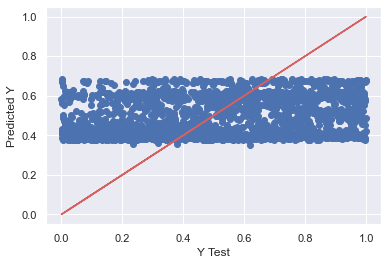

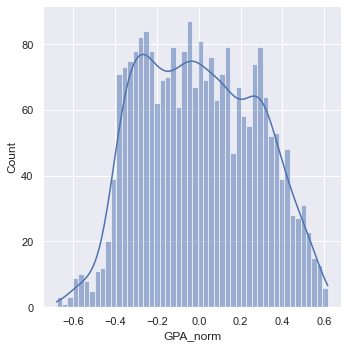

In [67]:
predictions_opt = drop_model.predict(X_test)
predictions_opt = predictions_opt.reshape(predictions_opt.shape[0])
plt.scatter(y_test,predictions_opt)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.plot(y_test,y_test,'r')
#plt.axis([15, 20, 15., 20])

sns.displot((y_test-predictions_opt),bins=50, kde=True);

## Random Forest regressor

MAE: 0.2288548117036192
MSE: 0.0727556895937348
RMSE: 0.2697326261202652


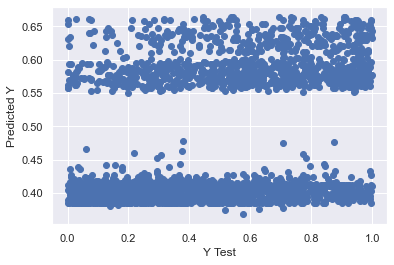

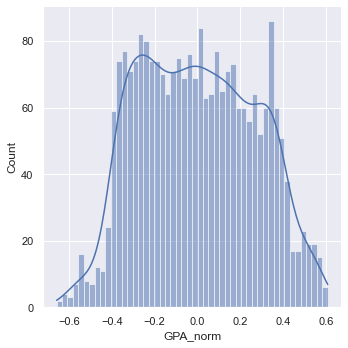

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

rf_predictions = rf.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, rf_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rf_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_predictions)))

rf_predictions = rf_predictions.reshape(predictions.shape[0])
plt.scatter(y_test,rf_predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([10, 20, 15., 18])

sns.displot((y_test-rf_predictions),bins=50, kde=True);


In [51]:
log_entry = pd.DataFrame([["Random Forest", metrics.mean_absolute_error(y_test, rf_predictions), 
                           metrics.mean_squared_error(y_test, rf_predictions),
                           np.sqrt(metrics.mean_squared_error(y_test, rf_predictions))
                           ]], columns=log_cols)
log = log.append(log_entry)

Variable: Department           Importance: 0.729
Variable: Year                 Importance: 0.089
Variable: Age                  Importance: 0.065
Variable: Grade                Importance: 0.037
Variable: Type                 Importance: 0.025
Variable: Gender               Importance: 0.023
Variable: Marital status       Importance: 0.014
Variable: Children             Importance: 0.012
Variable: Nationality          Importance: 0.003
Variable: Financial Aid        Importance: 0.002


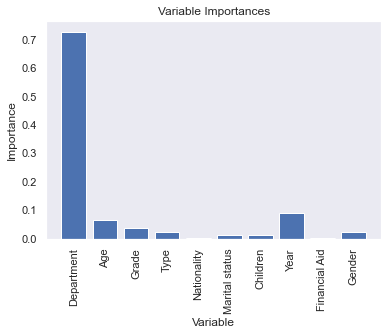

In [52]:
# Get numerical feature importances
feature_list = X.columns

importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid()

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

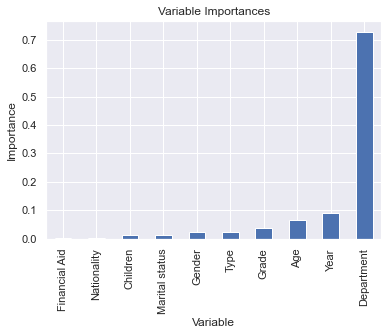

In [53]:
coeff_df_rf = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['Coefficient'])
coeff_df_rf['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

## Decision Tree Regresor

MAE: 0.24604163395556639
MSE: 0.08892010525078842
RMSE: 0.29819474383494493


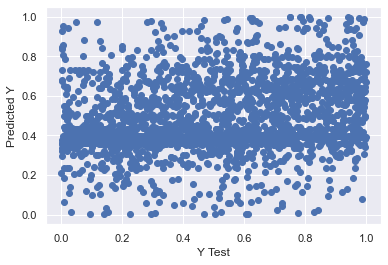

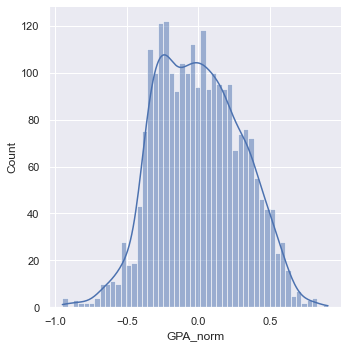

In [54]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 18).fit(X_train, y_train)

dt_predictions = dt.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, dt_predictions))
print('MSE:', metrics.mean_squared_error(y_test, dt_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dt_predictions)))

dt_predictions = dt_predictions.reshape(predictions.shape[0])
plt.scatter(y_test,dt_predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
#plt.plot(y_test,y_test,'r')
#plt.axis([12, 20, 15., 18])

sns.displot((y_test-dt_predictions),bins=50, kde=True);


In [55]:
log_entry = pd.DataFrame([["Decision Tree", metrics.mean_absolute_error(y_test, dt_predictions), 
                           metrics.mean_squared_error(y_test, dt_predictions),
                           np.sqrt(metrics.mean_squared_error(y_test, dt_predictions))
                           ]], columns=log_cols)
log = log.append(log_entry)

Variable: Department           Importance: 0.373
Variable: Age                  Importance: 0.236
Variable: Year                 Importance: 0.095
Variable: Grade                Importance: 0.07
Variable: Gender               Importance: 0.058
Variable: Children             Importance: 0.055
Variable: Marital status       Importance: 0.054
Variable: Type                 Importance: 0.041
Variable: Nationality          Importance: 0.013
Variable: Financial Aid        Importance: 0.005


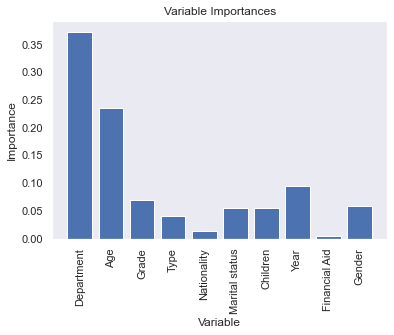

In [56]:

# Get numerical feature importances
feature_list = X.columns

importances = list(dt.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
plt.grid()

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

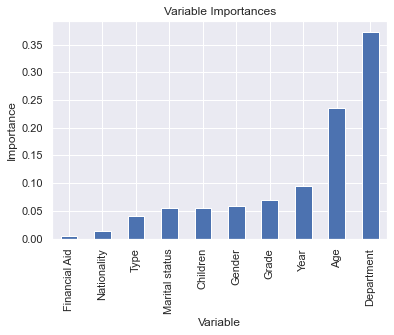

In [57]:
coeff_df_dt = pd.DataFrame(dt.feature_importances_,index=X.columns,columns=['Coefficient'])
coeff_df_dt['Coefficient'].sort_values()[:].plot(kind='bar', grid=1)
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [58]:
#log = log.drop(['Neural Network'], axis=0, inplace=True)
log.head()

,Classifier,MAE,MSE,RMSE
0,Linear Regression,0.233001,0.075578,0.274914
0,Neural Network,0.232916,0.075773,0.275270
0,Random Forest,0.228855,0.072756,0.269733
0,Decision Tree,0.246042,0.088920,0.298195


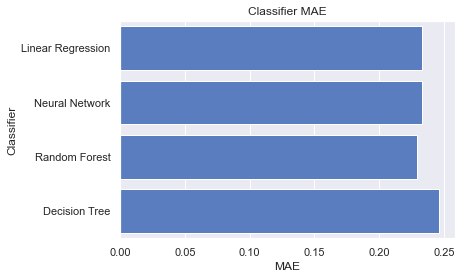

In [59]:
plt.xlabel('MAE')
plt.title('Classifier MAE')

sns.set_color_codes("muted")
sns.barplot(x='MAE', y='Classifier', data=log, color="b");

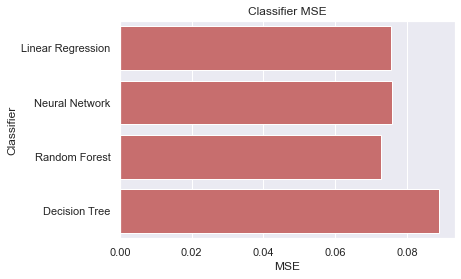

In [60]:
plt.xlabel('MSE')
plt.title('Classifier MSE')

sns.set_color_codes("muted")
sns.barplot(x='MSE', y='Classifier', data=log, color="r");

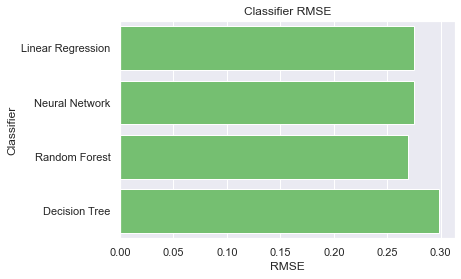

In [61]:
plt.xlabel('RMSE')
plt.title('Classifier RMSE')

sns.set_color_codes("muted")
sns.barplot(x='RMSE', y='Classifier', data=log, color="g");

## Department exclusive

In [162]:
print(df_test['Danshkadeh'].value_counts())
faculty_recrod = np.sort(list(df_test['Danshkadeh'].unique()))
# df for all departments
faculty_df = [df_test[df_test['Danshkadeh'] == i] for i in faculty_recrod]

def train_NN(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(16,activation='relu'))
    model.add(Dense(16,activation='relu'))    
    model.add(Dense(1))

    # early stopping callback
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    model.compile(optimizer='adam',loss='mse')
    model.fit(x=X_train,y=y_train.values,
            validation_data=(X_test,y_test.values),
            batch_size=128, epochs=20, verbose=False, callbacks=[early_stopping])
    def predictor(model):        
        NN_pred = model.predict(X_test)
        print('MAE:', metrics.mean_absolute_error(y_test, NN_pred))
        print('MSE:', metrics.mean_squared_error(y_test, NN_pred))
        print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, NN_pred)))
        print("---------------------------------\n")
    #predictor(model)  
    #NN_pred = model.predict(X_test)
    #mae = metrics.mean_absolute_error(y_test, NN_pred)
    #mse = metrics.mean_squared_error(y_test, NN_pred)
    #rmse =   np.sqrt(mse)
    #return model, mae, mse, rmse
    return model

model_list = []
for df in faculty_df:
    print("Department class:", df['Danshkadeh'].unique())
    X = df.drop(['Moadel'], axis=1) 
    y = df['Moadel']    
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model_list.append(train_NN(X_train, y_train, X_test, y_test))

1    6713
4    3918
2    2089
3     989
Name: Danshkadeh, dtype: int64
Department class: [1]
Department class: [2]
Department class: [3]
Department class: [4]


In [160]:
model_list

[(<keras.engine.sequential.Sequential at 0x7f9be2dad1c0>,
  1.6532554740792145,
  4.640341284666247,
  2.154145140111559),
 (<keras.engine.sequential.Sequential at 0x7f9c03860490>,
  3.2421408933429623,
  15.924685085716174,
  3.9905745307807714),
 (<keras.engine.sequential.Sequential at 0x7f9bf3ff0f10>,
  7.955107239520912,
  72.61851881395151,
  8.521650005365833),
 (<keras.engine.sequential.Sequential at 0x7f9bf5264b50>,
  1.6985712556449735,
  4.68817795396485,
  2.165220070562078)]

<Axes: >

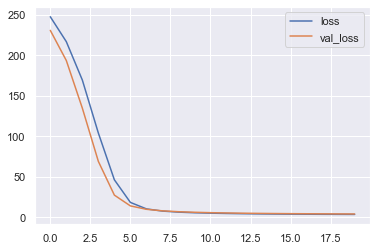

In [163]:
losses = pd.DataFrame(model_list[0].history.history)
losses.plot()

<Axes: >

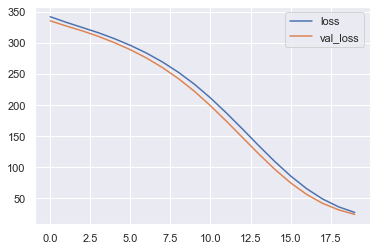

In [149]:
losses = pd.DataFrame(model_list[1].history.history)
losses.plot()

<Axes: >

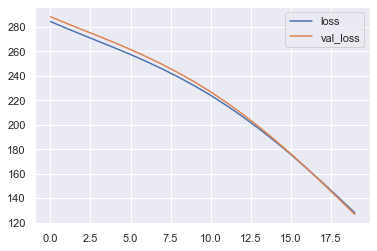

In [150]:
losses = pd.DataFrame(model_list[2].history.history)
losses.plot()

<Axes: >

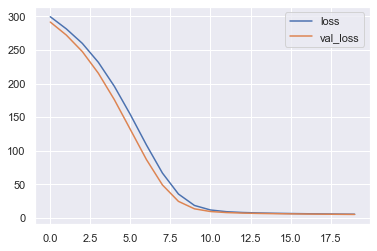

In [151]:
losses = pd.DataFrame(model_list[3].history.history)
losses.plot()